# Federated Learning with BraTS 2021 Dataset
This notebook implements a federated learning framework for brain tumor segmentation using the BraTS 2021 dataset.

In [46]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [47]:
images_path = 'Data/BraTS2021'
IMG_SIZE = 128  # Resize images to 128x128
VOLUME_SLICES = 50  # Number of slices per patient
VOLUME_START_AT = 22  # Start slicing from this index
REDUCE_PATIENTS = False  # Option to reduce the number of patients per hospital
PATIENT_LIMIT = 10  # Number of patients per hospital if REDUCE_PATIENTS is Tru

# Load the dataset file paths
all_patients = [os.path.join(images_path, p) for p in os.listdir(images_path)]
np.random.shuffle(all_patients)

In [48]:
# Split dataset among hospitals (nodes)
nodes = {
    "Hospital_1": all_patients[:len(all_patients)//3],
    "Hospital_2": all_patients[len(all_patients)//3:2*len(all_patients)//3],
    "Hospital_3": all_patients[2*len(all_patients)//3:]
}

print(len(all_patients))

1251


In [49]:
# Define Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(images_path, os.path.basename(i), os.path.basename(i))
            flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ce = nib.load(f'{case_path}_t1ce.nii').get_fdata()
            seg = nib.load(f'{case_path}_seg.nii').get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3  # Adjust class values
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return X / np.max(X), Y

In [50]:
# Define dataset split ratios
train_ratio = 0.7
val_ratio = 0.15  # (0.85 - 0.7)
test_ratio = 0.15  # Remaining percentage

# Distribute dataset into train, validation, and test sets
hospitals_data = {}
for hospital, files in nodes.items():
    np.random.shuffle(files)
    
    train_split = int(train_ratio * len(files))
    val_split = int((train_ratio + val_ratio) * len(files))
    
    hospitals_data[hospital] = {
        "train": DataGenerator(files[:train_split]),
        "val": DataGenerator(files[train_split:val_split]),
        "test": DataGenerator(files[val_split:])
    }

    # Print dataset shapes for each hospital
    print(f"{hospital}: Train={len(hospitals_data[hospital]['train'])}, "
          f"Val={len(hospitals_data[hospital]['val'])}, "
          f"Test={len(hospitals_data[hospital]['test'])}")


Hospital_1: Train=291, Val=63, Test=63
Hospital_2: Train=291, Val=63, Test=63
Hospital_3: Train=291, Val=63, Test=63


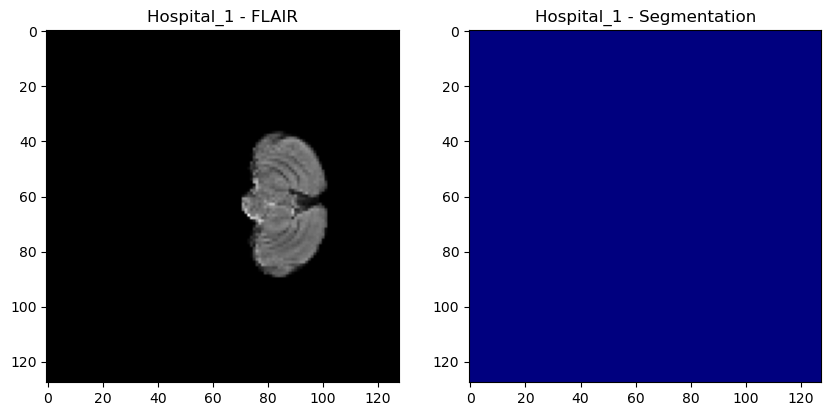

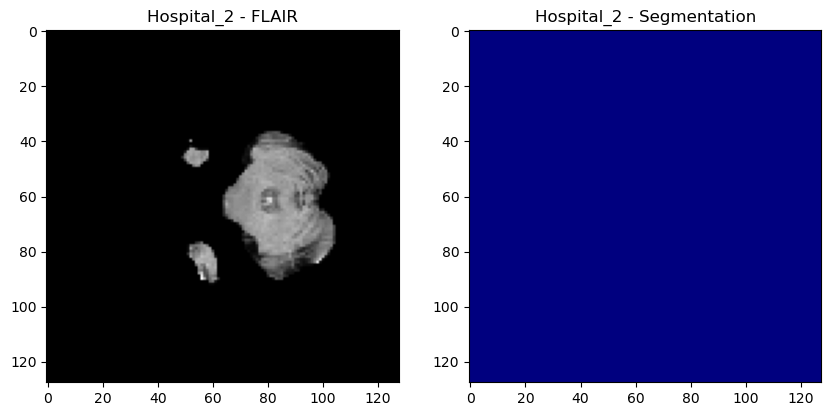

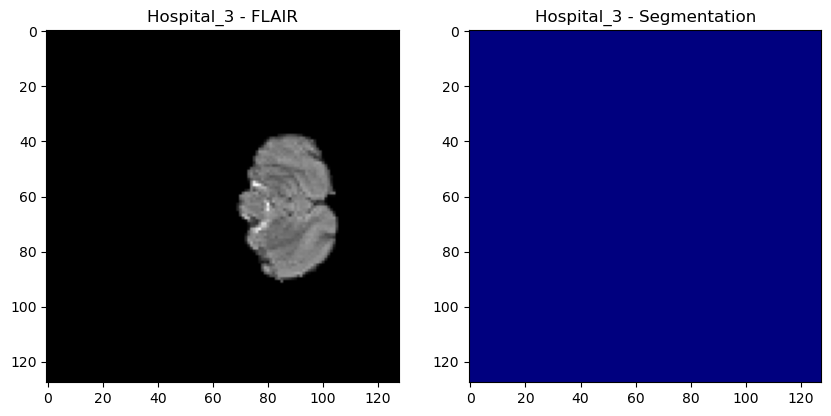

In [51]:
# Visualize Some Slices from Each Hospital
for hospital, data in hospitals_data.items():
    X_sample, y_sample = data['train'].__getitem__(0)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_sample[0, :, :, 0], cmap='gray')
    ax[0].set_title(f"{hospital} - FLAIR")
    ax[1].imshow(np.argmax(y_sample[0], axis=-1), cmap='jet')
    ax[1].set_title(f"{hospital} - Segmentation")
    plt.show()

In [52]:
## Cell 5: Define UNet model with proper upsampling
def create_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 2)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(4, (4, 4), strides=(4, 4), activation='softmax', padding='same')(x)  # Proper upsampling
    return keras.Model(inputs, x)

In [53]:
# Initialize models for each hospital
local_models = {}
for hospital in hospitals_data.keys():
    local_models[hospital] = create_unet_model()

In [54]:
num_rounds = 5
global_model = create_unet_model()

def federated_averaging(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(np.mean(weights, axis=0))
    return avg_weights


In [55]:
for round_num in range(num_rounds):
    local_weights = []
    
    for hospital in hospitals_data.keys():
        print(f"Training {hospital}...")

        # Free memory before training each hospital
        tf.keras.backend.clear_session()

        # Create a fresh model to avoid memory leak
        local_model = create_unet_model()
        local_model.set_weights(global_model.get_weights())
        
        # Compile and train
        local_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        local_model.fit(hospitals_data[hospital]['train'], epochs=10, validation_data=hospitals_data[hospital]['val'])
        
        # Save trained weights
        local_weights.append(local_model.get_weights())

    new_global_weights = federated_averaging(local_weights)
    global_model.set_weights(new_global_weights)


Training Hospital_1...
Epoch 1/10
 47/291 ━━━━━━━━━━━━━━━━━━━━ 2:50 700ms/step - accuracy: 0.9381 - loss: 0.9516

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: [WinError 8] Not enough memory resources are available to process this command
Traceback (most recent call last):

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_7396\2993538711.py", line 17, in __getitem__
    X, y = self.__data_generation(Batch_ids)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_7396\2993538711.py", line 31, in __data_generation
    flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\dataobj_images.py", line 373, in get_fdata
    data = np.asanyarray(self._dataobj, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 457, in __array__
    arr = self._get_scaled(dtype=dtype, slicer=())
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 424, in _get_scaled
    scaled = apply_read_scaling(self._get_unscaled(slicer=slicer), scl_slope, scl_inter)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 394, in _get_unscaled
    return array_from_file(
           ^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\volumeutils.py", line 450, in array_from_file
    return np.memmap(infile, in_dtype, mode=mode, shape=shape, order=order, offset=offset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\memmap.py", line 268, in __new__
    mm = mmap.mmap(fid.fileno(), bytes, access=acc, offset=start)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

OSError: [WinError 8] Not enough memory resources are available to process this command


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_90841]

In [45]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate the global model on each hospital's test set
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.9862 - loss: 0.0602
Global Model - Hospital_1: Accuracy = 0.9880, Loss = 0.0548
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.9865 - loss: 0.0605
Global Model - Hospital_2: Accuracy = 0.9878, Loss = 0.0560
31/63 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step - accuracy: 0.9896 - loss: 0.0513

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: [WinError 8] Not enough memory resources are available to process this command
Traceback (most recent call last):

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_7396\2993538711.py", line 17, in __getitem__
    X, y = self.__data_generation(Batch_ids)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_7396\2993538711.py", line 31, in __data_generation
    flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\dataobj_images.py", line 373, in get_fdata
    data = np.asanyarray(self._dataobj, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 457, in __array__
    arr = self._get_scaled(dtype=dtype, slicer=())
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 424, in _get_scaled
    scaled = apply_read_scaling(self._get_unscaled(slicer=slicer), scl_slope, scl_inter)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 394, in _get_unscaled
    return array_from_file(
           ^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\volumeutils.py", line 450, in array_from_file
    return np.memmap(infile, in_dtype, mode=mode, shape=shape, order=order, offset=offset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\memmap.py", line 268, in __new__
    mm = mmap.mmap(fid.fileno(), bytes, access=acc, offset=start)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

OSError: [WinError 8] Not enough memory resources are available to process this command


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_85270]

In [ ]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate on each hospital's test set
global_results = {}
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    global_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.9915 - loss: 0.0459
Global Model - Hospital_1: Accuracy = 0.9911, Loss = 0.0469
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.9949 - loss: 0.0267
Global Model - Hospital_2: Accuracy = 0.9937, Loss = 0.0307
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.9870 - loss: 0.0629
Global Model - Hospital_3: Accuracy = 0.9856, Loss = 0.0687


In [ ]:
# Ensure local models are compiled before evaluation
local_results = {}
for hospital, model in local_models.items():
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    loss, acc = model.evaluate(hospitals_data[hospital]['test'])
    local_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Local Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")

# Compare local vs. global accuracy
for hospital in hospitals_data.keys():
    print(f"{hospital} - Local Model Accuracy: {local_results[hospital]['Accuracy']:.4f}, Global Model Accuracy: {global_results[hospital]['Accuracy']:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.7223 - loss: 1.3862
Local Model - Hospital_1: Accuracy = 0.7133, Loss = 1.3862
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.6718 - loss: 1.3866
Local Model - Hospital_2: Accuracy = 0.6759, Loss = 1.3866
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.6628 - loss: 1.3868
Local Model - Hospital_3: Accuracy = 0.6743, Loss = 1.3867
Hospital_1 - Local Model Accuracy: 0.7133, Global Model Accuracy: 0.9911
Hospital_2 - Local Model Accuracy: 0.6759, Global Model Accuracy: 0.9937
Hospital_3 - Local Model Accuracy: 0.6743, Global Model Accuracy: 0.9856


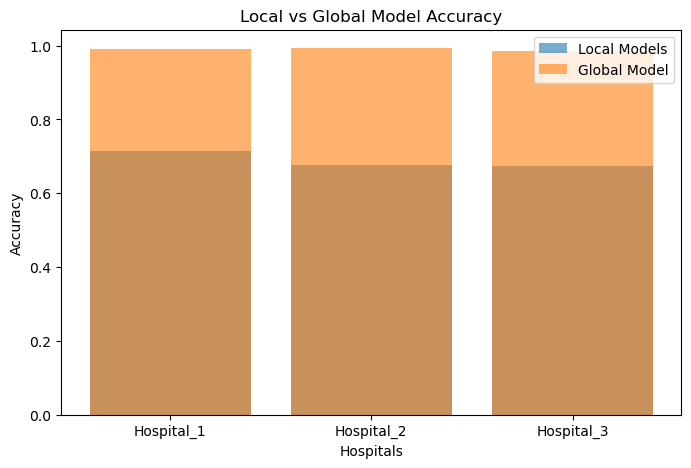

In [ ]:
# Extract accuracy values
hospitals = list(hospitals_data.keys())
local_accuracies = [local_results[h]["Accuracy"] for h in hospitals]
global_accuracies = [global_results[h]["Accuracy"] for h in hospitals]

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(hospitals, local_accuracies, alpha=0.6, label="Local Models")
plt.bar(hospitals, global_accuracies, alpha=0.6, label="Global Model")
plt.xlabel("Hospitals")
plt.ylabel("Accuracy")
plt.title("Local vs Global Model Accuracy")
plt.legend()
plt.show()


Confusion Matrix for Hospital_1 - Local Model
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


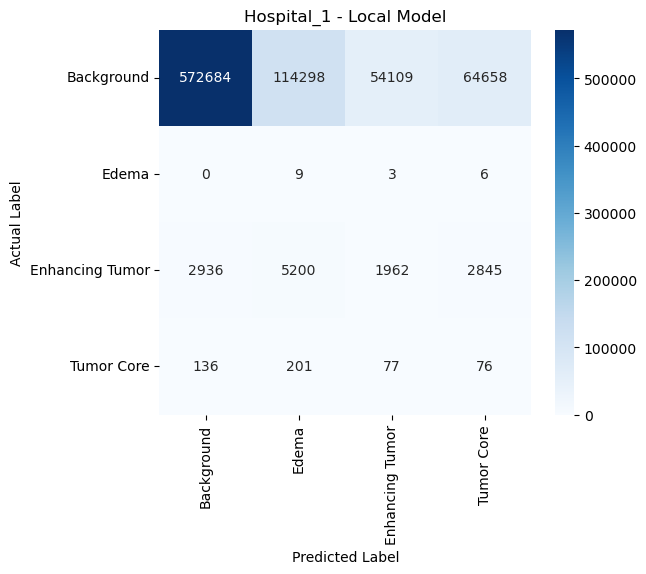

Confusion Matrix for Hospital_1 - Global Model
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


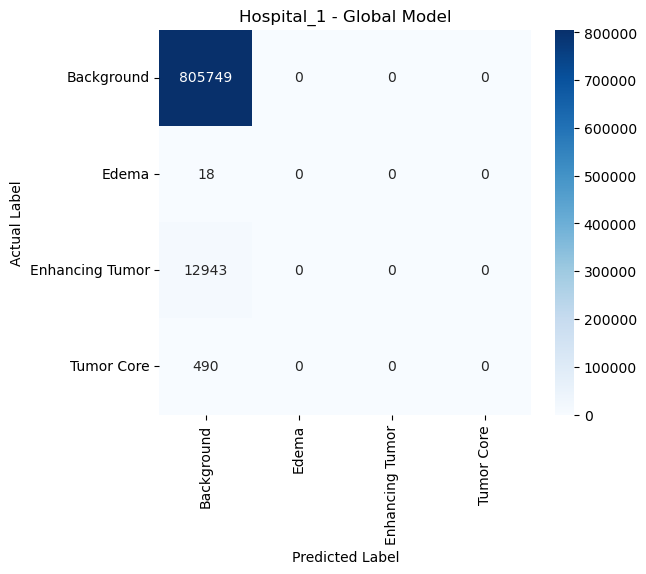

Confusion Matrix for Hospital_2 - Local Model
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


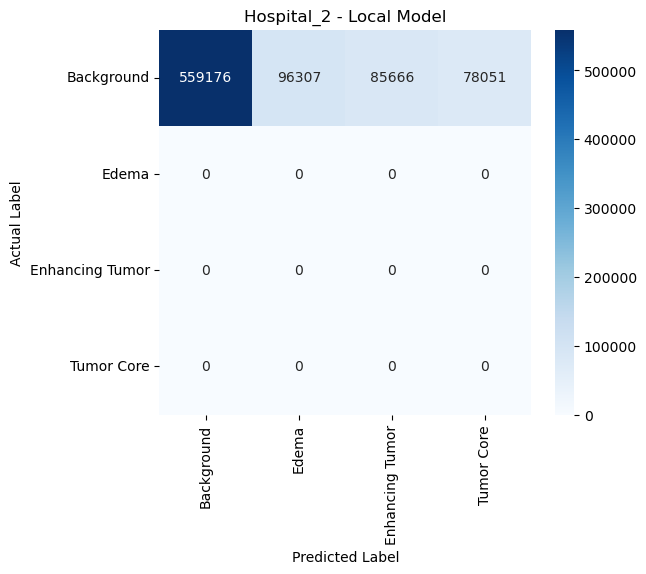

Confusion Matrix for Hospital_2 - Global Model
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


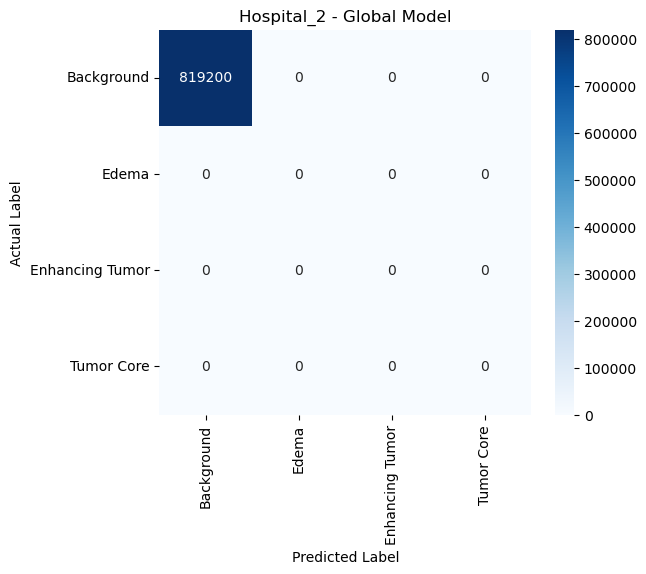

Confusion Matrix for Hospital_3 - Local Model
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


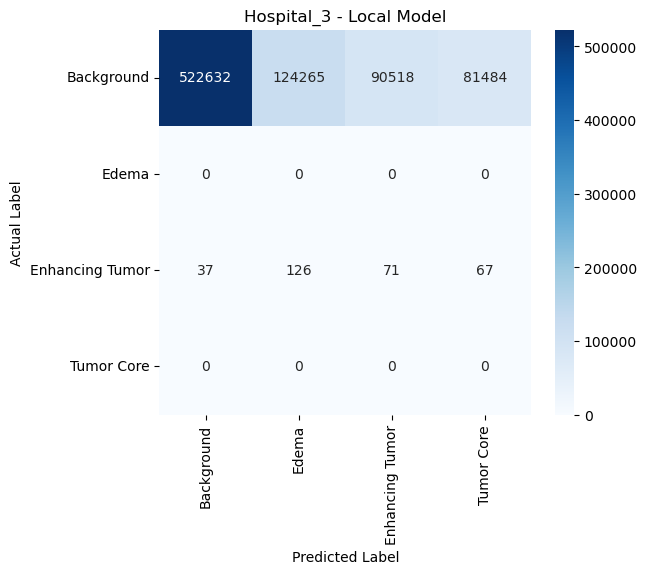

Confusion Matrix for Hospital_3 - Global Model
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


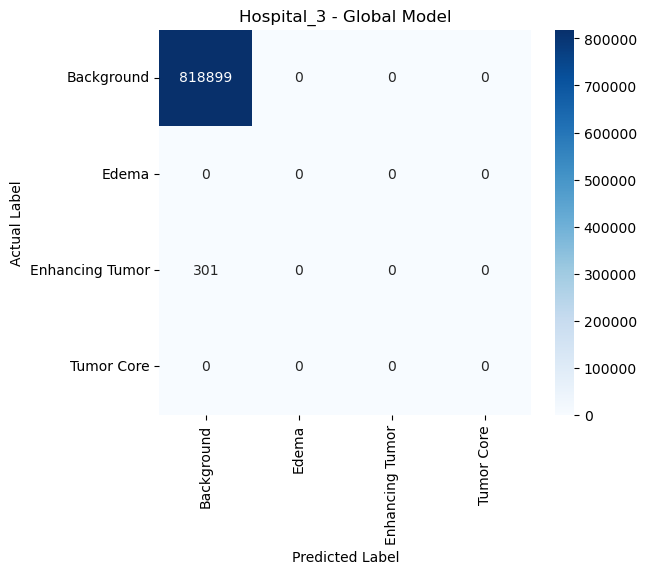

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define tumor subregion class labels
tumor_labels = ["Background", "Edema", "Enhancing Tumor", "Tumor Core"]

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tumor_labels, yticklabels=tumor_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()

# Compute Confusion Matrix for Each Model
for hospital, data in hospitals_data.items():
    print(f"Confusion Matrix for {hospital} - Local Model")
    X_batch, y_batch = data["test"].__getitem__(0)
    
    y_true = np.argmax(y_batch, axis=-1).flatten()  # Flatten ground truth labels
    y_pred = np.argmax(local_models[hospital].predict(X_batch), axis=-1).flatten()  # Flatten predictions
    
    plot_confusion_matrix(y_true, y_pred, title=f"{hospital} - Local Model")

    print(f"Confusion Matrix for {hospital} - Global Model")
    y_pred_global = np.argmax(global_model.predict(X_batch), axis=-1).flatten()  # Flatten global model predictions
    
    plot_confusion_matrix(y_true, y_pred_global, title=f"{hospital} - Global Model")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━

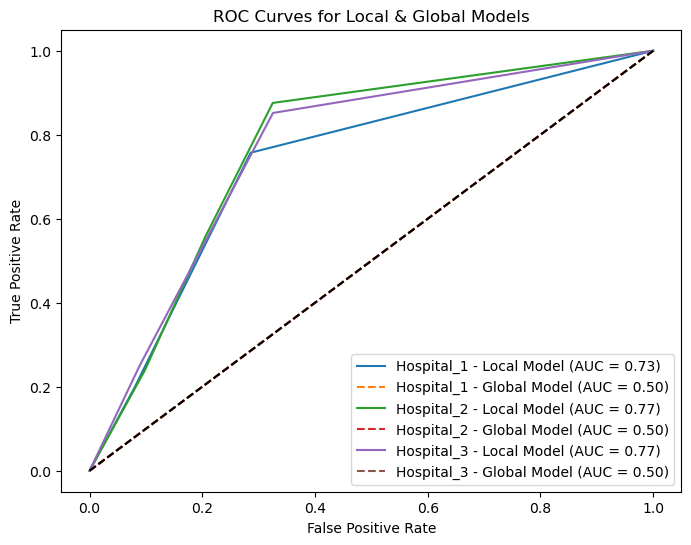

In [25]:
# Plot ROC Curves for Local and Global Models
plt.figure(figsize=(8, 6))

for hospital, data in hospitals_data.items():
    y_true_list, y_pred_list, y_pred_global_list = [], [], []

    for i in range(len(data["test"])):
        X_batch, y_batch = data["test"].__getitem__(i)
        y_true_list.append(np.argmax(y_batch, axis=-1).flatten())
        y_pred_list.append(np.argmax(local_models[hospital].predict(X_batch), axis=-1).flatten())
        y_pred_global_list.append(np.argmax(global_model.predict(X_batch), axis=-1).flatten())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    y_pred_global = np.concatenate(y_pred_global_list)

    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel(), pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{hospital} - Local Model (AUC = {roc_auc:.2f})")

    fpr_g, tpr_g, _ = roc_curve(y_true.ravel(), y_pred_global.ravel(), pos_label=1)
    roc_auc_g = auc(fpr_g, tpr_g)
    plt.plot(fpr_g, tpr_g, linestyle="dashed", label=f"{hospital} - Global Model (AUC = {roc_auc_g:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Local & Global Models")
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━

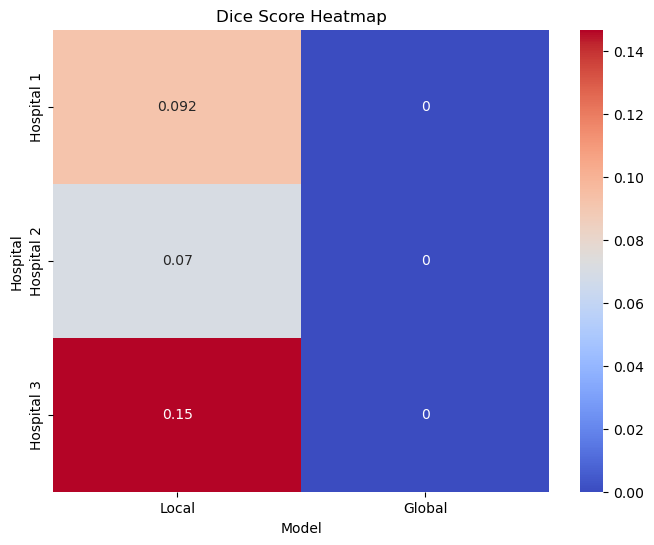

In [26]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice_scores = np.zeros((3, 2))  # 3 hospitals, 2 models (Local & Global)

for i, (hospital, data) in enumerate(hospitals_data.items()):
    y_true_list, y_pred_list, y_pred_global_list = [], [], []

    for j in range(len(data["test"])):
        X_batch, y_batch = data["test"].__getitem__(j)
        y_true_list.append(np.argmax(y_batch, axis=-1))
        y_pred_list.append(np.argmax(local_models[hospital].predict(X_batch), axis=-1))
        y_pred_global_list.append(np.argmax(global_model.predict(X_batch), axis=-1))

    y_true = np.concatenate(y_true_list).flatten()
    y_pred = np.concatenate(y_pred_list).flatten()
    y_pred_global = np.concatenate(y_pred_global_list).flatten()

    dice_scores[i, 0] = dice_coefficient(y_true, y_pred)  # Local
    dice_scores[i, 1] = dice_coefficient(y_true, y_pred_global)  # Global

plt.figure(figsize=(8, 6))
sns.heatmap(dice_scores, annot=True, cmap="coolwarm", xticklabels=["Local", "Global"], yticklabels=["Hospital 1", "Hospital 2", "Hospital 3"])
plt.title("Dice Score Heatmap")
plt.xlabel("Model")
plt.ylabel("Hospital")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Boundary Overlay - Hospital_1 (Local Model)


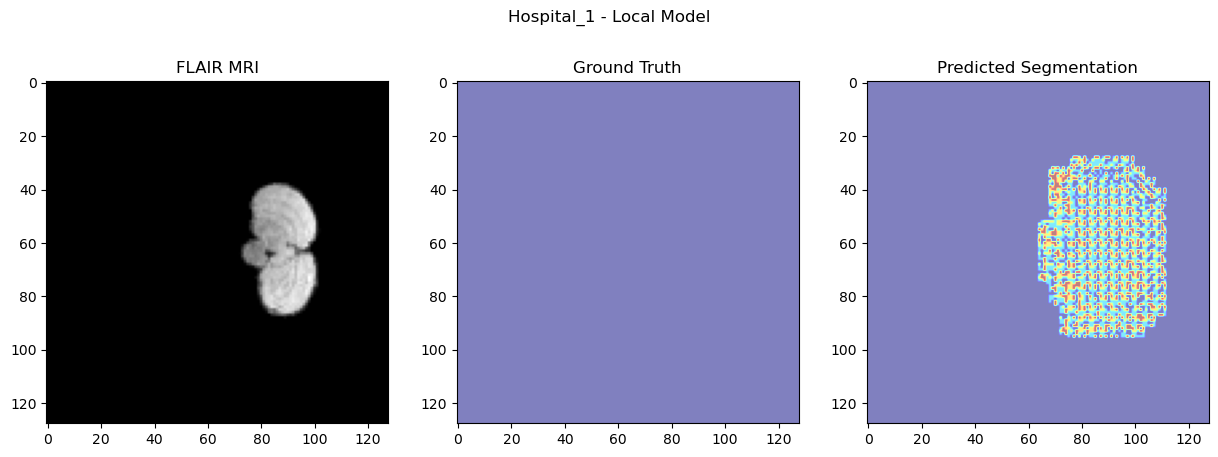

Boundary Overlay - Hospital_1 (Global Model)


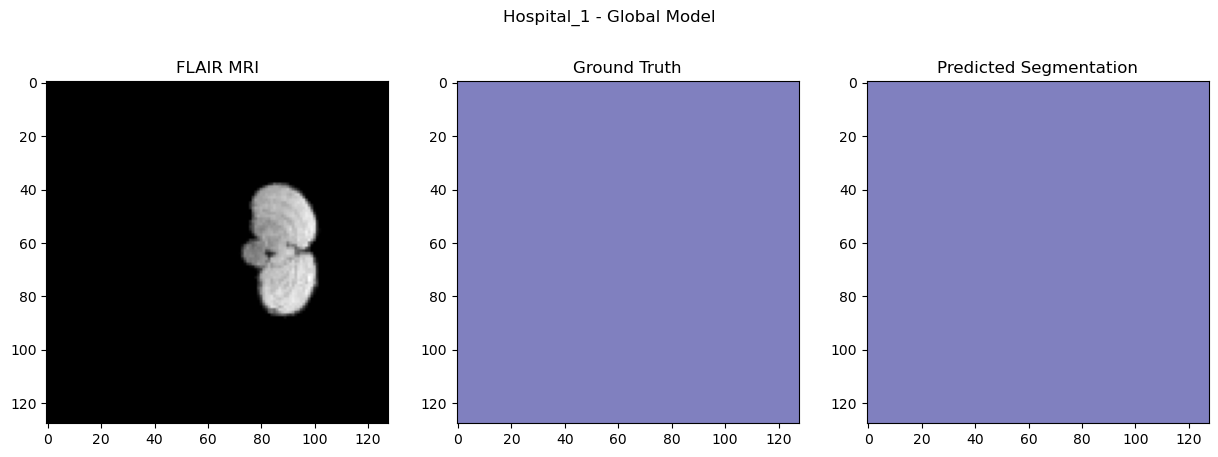

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Boundary Overlay - Hospital_2 (Local Model)


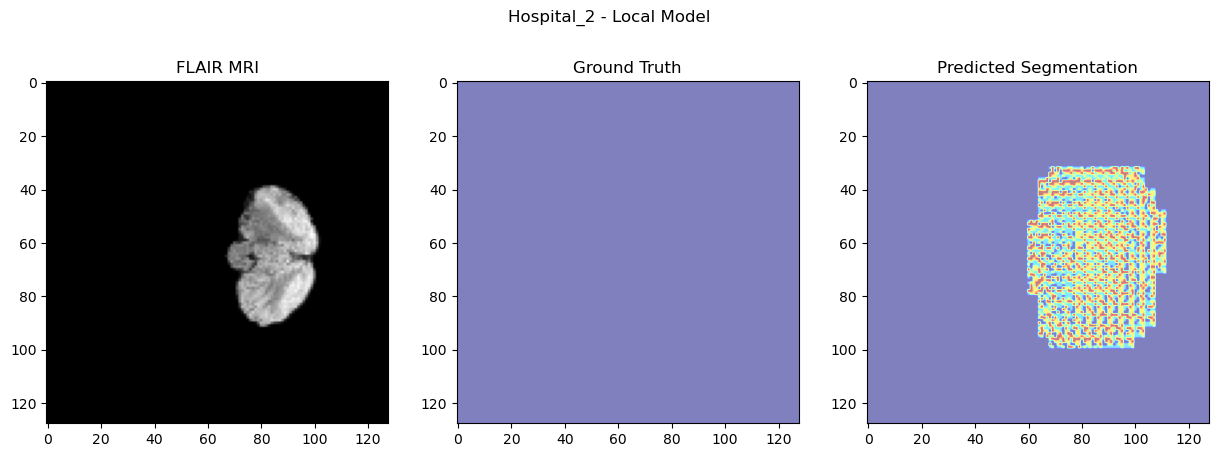

Boundary Overlay - Hospital_2 (Global Model)


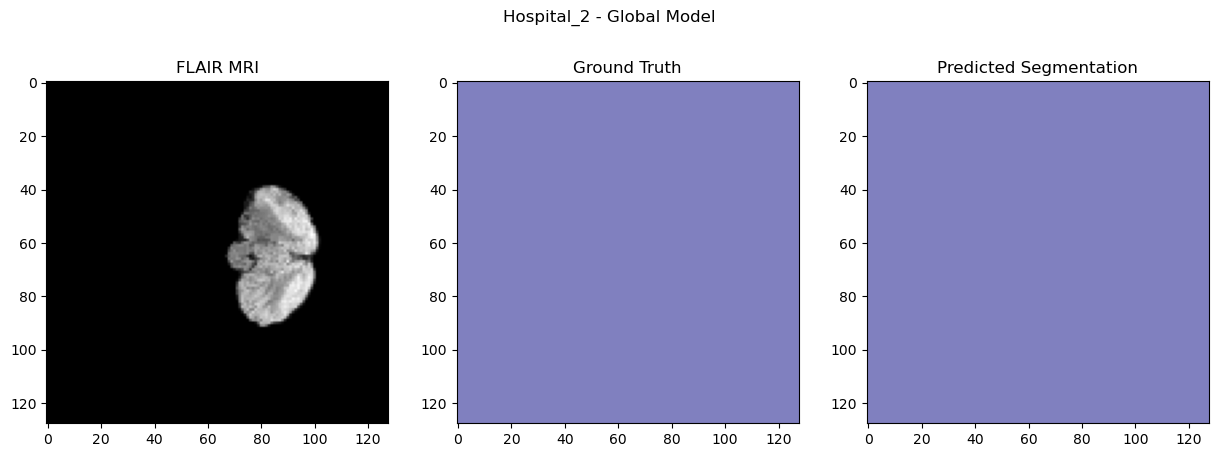

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Boundary Overlay - Hospital_3 (Local Model)


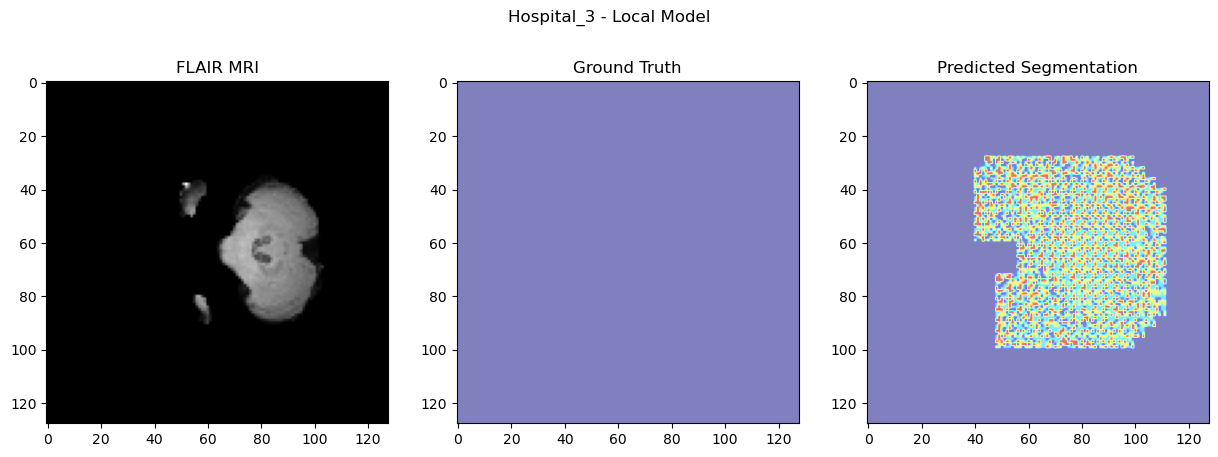

Boundary Overlay - Hospital_3 (Global Model)


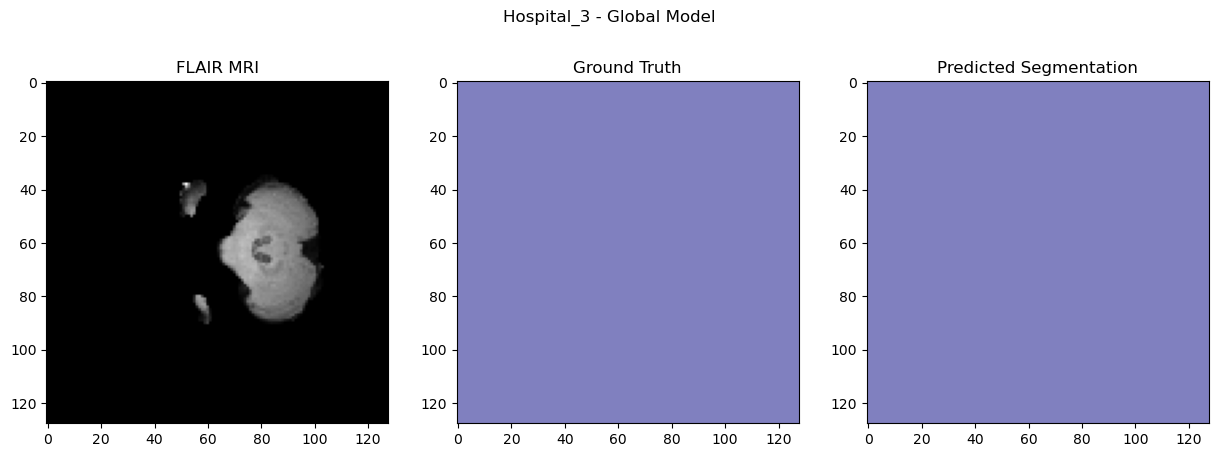

In [27]:
def plot_boundary_overlay(X, y_true, y_pred, title="Boundary Overlay"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(X[:, :, 0], cmap="gray")
    axes[0].set_title("FLAIR MRI")
    
    axes[1].imshow(np.argmax(y_true, axis=-1), cmap="jet", alpha=0.5)
    axes[1].set_title("Ground Truth")

    axes[2].imshow(np.argmax(y_pred, axis=-1), cmap="jet", alpha=0.5)
    axes[2].set_title("Predicted Segmentation")

    plt.suptitle(title)
    plt.show()

for hospital, data in hospitals_data.items():
    X_batch, y_batch = data["test"].__getitem__(0)
    y_pred = local_models[hospital].predict(X_batch)
    y_pred_global = global_model.predict(X_batch)

    print(f"Boundary Overlay - {hospital} (Local Model)")
    plot_boundary_overlay(X_batch[0], y_batch[0], y_pred[0], title=f"{hospital} - Local Model")

    print(f"Boundary Overlay - {hospital} (Global Model)")
    plot_boundary_overlay(X_batch[0], y_batch[0], y_pred_global[0], title=f"{hospital} - Global Model")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Class Distribution - Hospital_1 (Local Model)


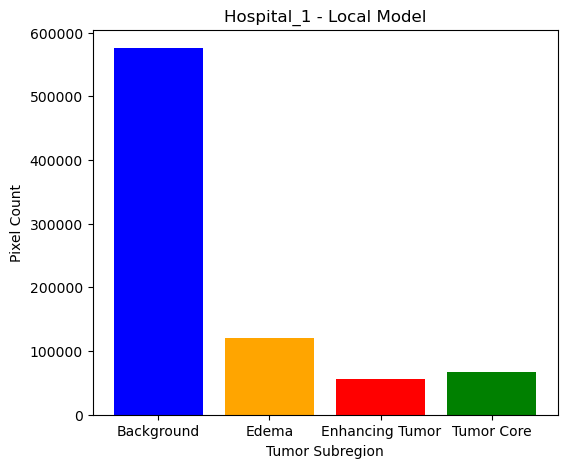

Class Distribution - Hospital_1 (Global Model)


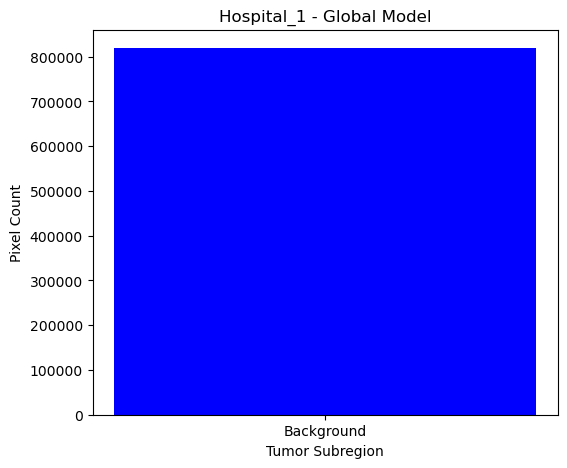

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Class Distribution - Hospital_2 (Local Model)


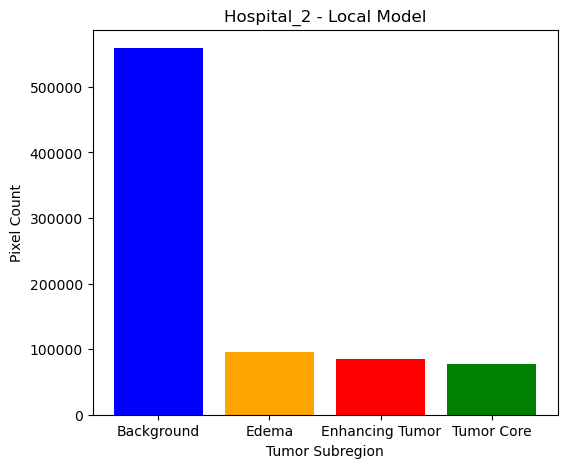

Class Distribution - Hospital_2 (Global Model)


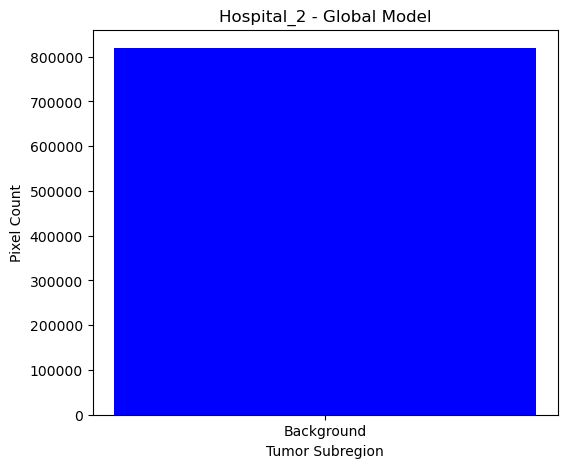

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Class Distribution - Hospital_3 (Local Model)


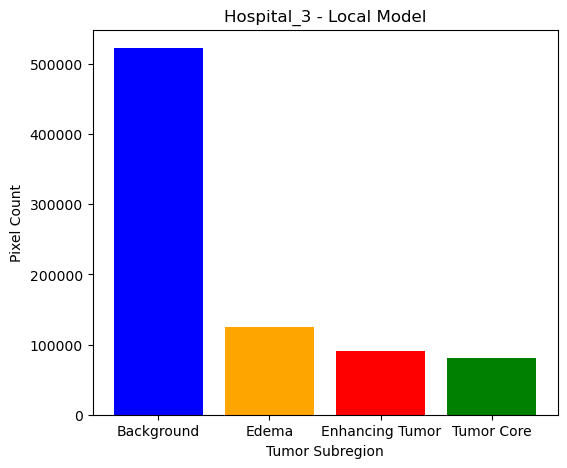

Class Distribution - Hospital_3 (Global Model)


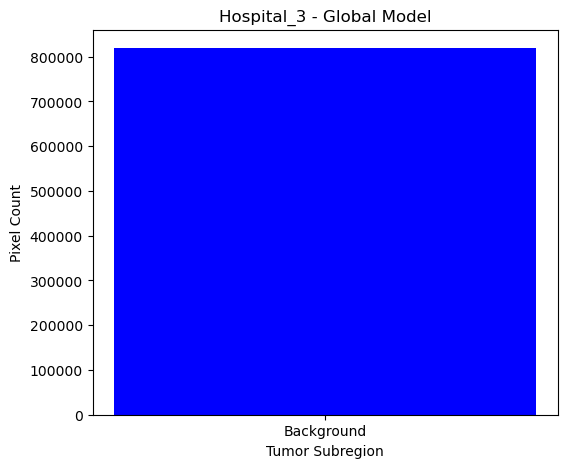

In [ ]:
def plot_class_distribution(y_pred, title="Class Distribution in Predictions"):
    unique, counts = np.unique(y_pred, return_counts=True)
    plt.figure(figsize=(6, 5))
    plt.bar([tumor_labels[i] for i in unique], counts, color=["blue", "orange", "red", "green"])
    plt.xlabel("Tumor Subregion")
    plt.ylabel("Pixel Count")
    plt.title(title)
    plt.show()

# Check class distribution for Local and Global Models
for hospital, data in hospitals_data.items():
    X_batch, y_batch = data["test"].__getitem__(0)
    
    y_pred_local = np.argmax(local_models[hospital].predict(X_batch), axis=-1)
    y_pred_global = np.argmax(global_model.predict(X_batch), axis=-1)

    print(f"Class Distribution - {hospital} (Local Model)")
    plot_class_distribution(y_pred_local, title=f"{hospital} - Local Model")

    print(f"Class Distribution - {hospital} (Global Model)")
    plot_class_distribution(y_pred_global, title=f"{hospital} - Global Model")


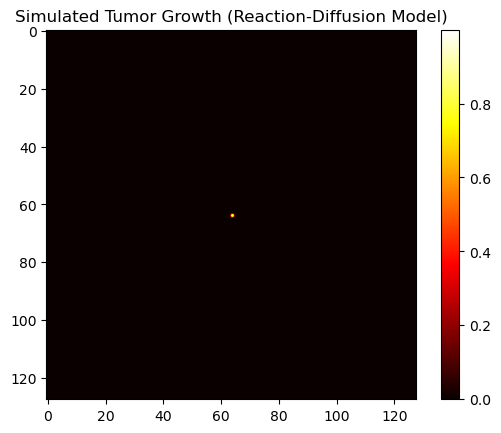

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters for reaction-diffusion model
def reaction_diffusion_simulation(size=128, time_steps=50, diffusion_rate=0.2, growth_rate=0.05):
    tumor = np.zeros((size, size))
    tumor[size//2, size//2] = 1  # Initial tumor seed
    
    for _ in range(time_steps):
        diffusion = gaussian_filter(tumor, sigma=diffusion_rate)
        tumor = diffusion + growth_rate * tumor * (1 - tumor)  # Growth term
        tumor = np.clip(tumor, 0, 1)
    
    return tumor

# Simulate and visualize
tumor_sim = reaction_diffusion_simulation()
plt.imshow(tumor_sim, cmap='hot')
plt.title("Simulated Tumor Growth (Reaction-Diffusion Model)")
plt.colorbar()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Create artificial tumor growth sequences
def generate_tumor_growth_series(num_samples=100, time_steps=10, size=128):
    series = []
    for _ in range(num_samples):
        tumor_series = []
        for t in range(time_steps):
            tumor_series.append(reaction_diffusion_simulation(size=size, time_steps=t))
        series.append(tumor_series)
    return np.array(series)

# Generate dataset
tumor_growth_series = generate_tumor_growth_series()
X_train = tumor_growth_series[:, :-1]  # All time steps except last
y_train = tumor_growth_series[:, -1]   # Last time step prediction target

print(f"Generated Tumor Growth Data: {X_train.shape} -> {y_train.shape}")


Generated Tumor Growth Data: (100, 9, 128, 128) -> (100, 128, 128)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten

# Define LSTM model
def build_lstm_model(input_shape=(9, 128, 128, 1)):
    model = Sequential([
        TimeDistributed(Flatten(), input_shape=input_shape),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(128 * 128, activation='sigmoid'),
        layers.Reshape((128, 128))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train LSTM model
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2)


Epoch 1/20


c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.2495 - mae: 0.4995 - val_loss: 0.2477 - val_mae: 0.4977
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.2470 - mae: 0.4970 - val_loss: 0.2447 - val_mae: 0.4946
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.2435 - mae: 0.4934 - val_loss: 0.2379 - val_mae: 0.4878
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.2333 - mae: 0.4829 - val_loss: 0.2046 - val_mae: 0.4522
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.1672 - mae: 0.4020 - val_loss: 0.0019 - val_mae: 0.0421
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.5237e-04 - mae: 0.0141 - val_loss: 1.1535e-12 - val_mae: 1.6759e-08
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.1535e-12 - mae: 1.6758e-08 - val_loss: 1.1535e-12 - val_mae: 1.6758e-08
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.1535e-12 - mae: 1.6758e-08 - val_loss: 1.1535e-12 - val_mae: 1.6758e-08
Epoch 9/20
10/10 ━━━━━━━━━━━━━

In [19]:
import gym
from gym import spaces

class TumorTreatmentEnv(gym.Env):
    def __init__(self):
        super(TumorTreatmentEnv, self).__init__()
        self.state = reaction_diffusion_simulation()
        self.action_space = spaces.Discrete(4)  # 0: No Treatment, 1: Radiotherapy, 2: Chemo, 3: Surgery
        self.observation_space = spaces.Box(low=0, high=1, shape=self.state.shape, dtype=np.float32)

    def step(self, action):
        # Apply treatment effects
        if action == 1:  # Radiotherapy
            self.state *= 0.9  # Shrink tumor slightly
        elif action == 2:  # Chemotherapy
            self.state *= 0.85  # Higher tumor shrinkage
        elif action == 3:  # Surgery
            self.state[:64, :64] = 0  # Remove tumor region (mock surgery)
        
        reward = -np.sum(self.state)  # Lower tumor = better reward
        done = np.sum(self.state) < 0.1  # Termination condition

        return self.state, reward, done, {}

    def reset(self):
        self.state = reaction_diffusion_simulation()
        return self.state

env = TumorTreatmentEnv()


In [ ]:
import gymnasium as gym
import stable_baselines3 as sb3
import shimmy

print("Shimmy Version:", shimmy.__version__)
print("Gymnasium Version:", gym.__version__)
print("Stable-Baselines3 Version:", sb3.__version__)


Shimmy Version: 2.0.0
Gymnasium Version: 1.0.0
Stable-Baselines3 Version: 2.5.0


In [ ]:
import stable_baselines3 as sb3

model = sb3.PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\binwa\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    fps             | 439      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.7        |
|    ep_rew_mean          | -11.9       |
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 2           |
|    time_elapsed         | 36          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014346216 |
|    clip_fraction        | 0.095       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00194    |
|    learning_rate        | 0.

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(y_train[0], cmap='hot')
axes[0].set_title("Real Tumor Growth")
axes[1].imshow(lstm_model.predict(X_train[0:1])[0], cmap='hot')
axes[1].set_title("Predicted Tumor Growth")
plt.show()


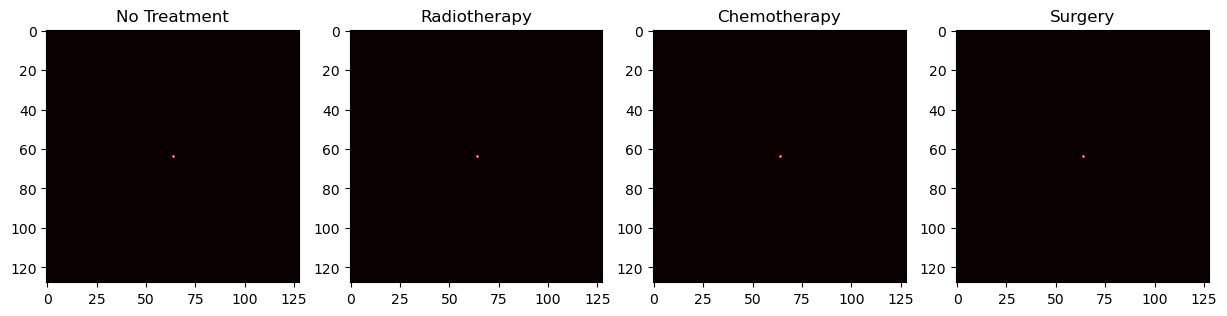

In [ ]:
treatment_results = []
for action in range(4):
    state = env.reset()
    for _ in range(10):
        state, _, _, _ = env.step(action)
    treatment_results.append(state)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
titles = ["No Treatment", "Radiotherapy", "Chemotherapy", "Surgery"]
for i, result in enumerate(treatment_results):
    axes[i].imshow(result, cmap='hot')
    axes[i].set_title(titles[i])
plt.show()
